In [1]:
import timm
import torch
from PIL import Image
import numpy as np

# %load "../segmentation.py"
import numpy as np
import cv2
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch

from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset

torch.manual_seed(0)

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def image_colorfulness(image):
	# split the image into its respective RGB components
	(B, G, R) = cv2.split(image.astype("float"))
	# compute rg = R - G
	rg = np.absolute(R - G)
	# compute yb = 0.5 * (R + G) - B
	yb = np.absolute(0.5 * (R + G) - B)
	# compute the mean and standard deviation of both `rg` and `yb`
	(rbMean, rbStd) = (np.mean(rg), np.std(rg))
	(ybMean, ybStd) = (np.mean(yb), np.std(yb))
	# combine the mean and standard deviations
	stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
	meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
	# derive the "colorfulness" metric and return it
	return stdRoot + (0.3 * meanRoot)

In [3]:
def get_ratio(image):
    h, w, _ = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]

    pixels = cv2.countNonZero(thresh)
    ratio = (pixels/(h * w)) * 100
    return ratio

In [4]:
# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    
    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    
    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return auto_result

100%|██████████| 3642/3642 [01:21<00:00, 44.76it/s]


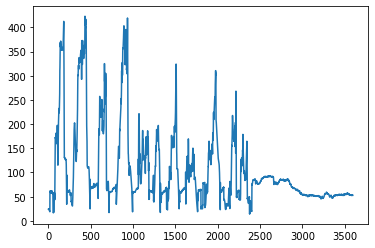

In [5]:
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt 
import math

video_location = "../test-videos/"
videos = ["testA_3.mp4"]
images_list = []
ratios_list = []
colors_list = []
metrics_list = []

for video in videos:
  vidcap = cv2.VideoCapture(video_location+video)
  fps = vidcap.get(cv2.CAP_PROP_FPS)      
  frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
  resized_image = []

  for i in tqdm(range(frame_count)):
    try:
      success,image = vidcap.read()
      image = image[256:896, 512:1400]
      image = automatic_brightness_and_contrast(image)
      image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
      resized_image.append(image)
    except:
      pass
  ratios = []
  colors = []
  metrics = []
  for img in resized_image:
    ratio = get_ratio(img[24:200, 24:200])
    color = image_colorfulness(img[24:200, 24:200])
    metric = color*color*ratio
    # colors.append(color)
    # ratios.append(ratio)
    metrics.append(math.sqrt(metric))
  
  images_list.append(resized_image)
  # ratios_list.append(ratios)
  # colors_list.append(colors)
  metrics_list.append(metrics)
  # print(video)
  plt.plot(metrics)
  plt.show()
  # plt.plot(ratios)
  # plt.show()
  # plt.plot(colors)
  # plt.show()

In [6]:
import scipy.fftpack as fftpack

def get_sharpness(image):
    im = Image.fromarray(image).convert('L') # to grayscale
    array = np.asarray(im, dtype=np.int32)

    gy, gx = np.gradient(array)
    gnorm = np.sqrt(gx**2 + gy**2)
    sharpness = np.average(gnorm)
    return sharpness

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

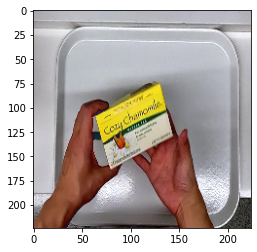

Color 52.92215466834172
Sharp 8.449913480287849
Metric 298.53653620083264


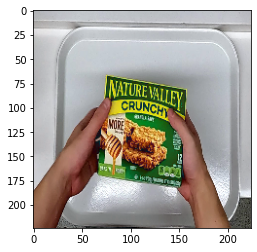

Color 46.18114215087851
Sharp 8.733768503647436
Metric 289.11143767877377


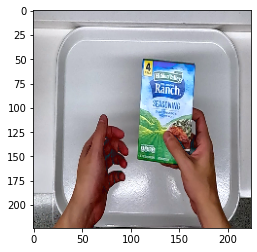

Color 40.34377629131743
Sharp 10.468466668360659
Metric 224.92366003946483


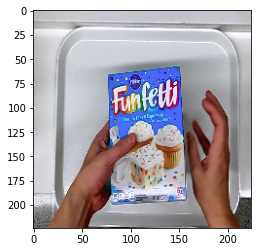

Color 53.16022757002765
Sharp 8.81563494490635
Metric 315.6491541646558


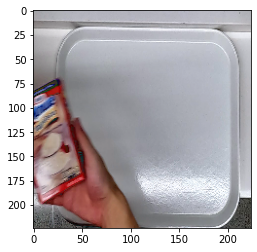

Color 31.120296266044484
Sharp 8.209840916317217
Metric 168.97132695751398


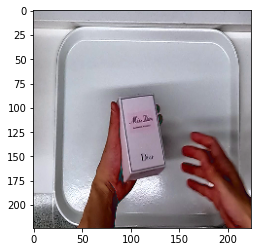

Color 30.06300420958329
Sharp 8.316023953621666
Metric 182.27902518408126


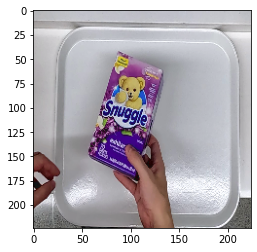

Color 36.2041482957148
Sharp 8.310754077823836
Metric 127.80253007463872


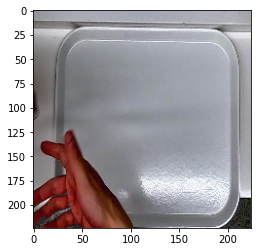

Color 24.5802804873323
Sharp 7.673553395158996
Metric 152.64426878480808


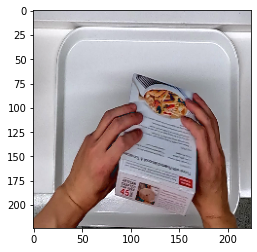

Color 35.52293754231809
Sharp 7.960243729204085
Metric 214.72375234876986


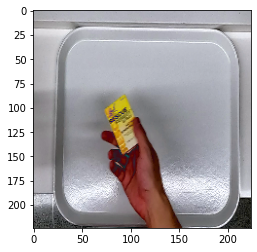

Color 19.67934166957684
Sharp 7.027205460225547
Metric 181.1861210266001


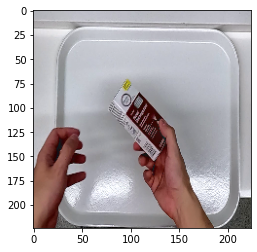

Color 30.490365527586345
Sharp 7.8097700783654584
Metric 121.58530286605145
Color 9.487021948728785
Sharp 7.089520254938264
Metric 37.48903466393549
Color 10.779543709616423
Sharp 8.319636959761274
Metric 47.40437073544358
Color 20.617249245858783
Sharp 6.829265721690802
Metric 34.40992398663259
Color 9.450553377869014
Sharp 7.880372727831313
Metric 35.364796111295355
Color 6.780753468860939
Sharp 7.73661091629583
Metric 25.9468382519102
Color 6.044062376992557
Sharp 7.761675739053267
Metric 21.837175142756518
Color 5.445553677425643
Sharp 7.73322235087627
Metric 53.15926902332039
Color 5.227550099453962
Sharp 7.757292396216243
Metric 21.321607970469703
Color 5.803584143377842
Sharp 7.423615540079204
Metric 54.27635478189642
Color 6.001611700495623
Sharp 7.375890155189327
Metric 57.238996701850205


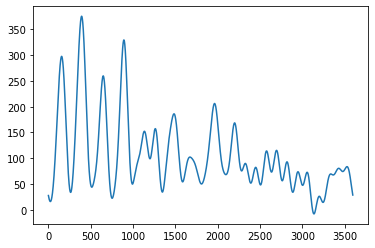

NEXT


In [7]:
from scipy.signal import savgol_filter, argrelextrema,find_peaks
import math
images_with_object = []

count = 1
for images, colors in zip(images_list, metrics_list):
    frames_with_object = []
    rolling_colors = smooth_data_fft(colors, 5)
    maximas = find_peaks(rolling_colors)
    for maxima in maximas[0]:
        candidate_frame = maxima
        max_sharpness = -1
        max_metric = -1
        for i in range(-21,22,7):
            current_frame = maxima+i
            if(current_frame>=len(images)):
                continue
            sharpness = get_sharpness(images[current_frame])
            colorfulness = image_colorfulness(images[current_frame])
            ratio = get_ratio(images[current_frame])
            metric = colorfulness*colorfulness * ratio
            metric = math.sqrt(metric)
            if(sharpness>max_sharpness and metric>max_metric):
                max_sharpness = sharpness
                max_metric = metric
                candidate_frame = current_frame
        if metric>110:
            frames_with_object.append((images[candidate_frame],candidate_frame))
            count+=1
            plt.imshow(images[candidate_frame][:,:,[2,1,0]])
            plt.show()

        print(f"Color {colorfulness}")
        print(f"Sharp {sharpness}")
        print(f"Metric {max_metric}")

    plt.plot(rolling_colors)
    plt.show()
    print("NEXT")
    images_with_object.append(frames_with_object)

In [52]:
image, frameCount = images_with_object[0][0]

In [53]:
dir = "for_paper/"

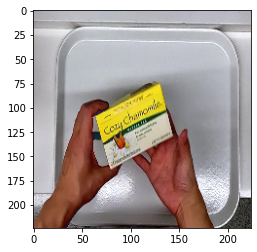

In [54]:
image = image[:,:,[2,1,0]]
plt.imshow(image)
plt.imsave("for_paper/normal.jpg",image)

In [55]:
h, w, _ = image.shape
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

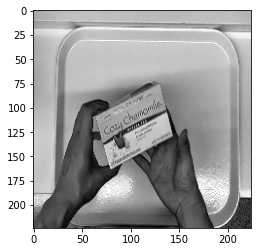

In [56]:
plt.imshow(gray, cmap='gray')
plt.imsave("for_paper/gray.jpg",gray, cmap="gray")

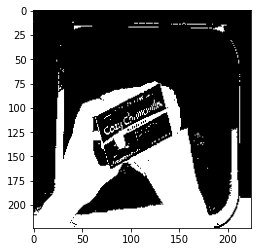

In [57]:
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]
plt.imshow(thresh, cmap="gray")
plt.imsave("for_paper/thresh.jpg",thresh, cmap="gray")

In [58]:

pixels = cv2.countNonZero(thresh)
ratio = (pixels/(h * w)) * 100

In [59]:
# split the image into its respective RGB components
(B, G, R) = cv2.split(image.astype("float"))
# compute rg = R - G
rg = np.absolute(R - G)
# compute yb = 0.5 * (R + G) - B
yb = np.absolute(0.5 * (R + G) - B)
# compute the mean and standard deviation of both `rg` and `yb`
(rbMean, rbStd) = (np.mean(rg), np.std(rg))
(ybMean, ybStd) = (np.mean(yb), np.std(yb)) 
# combine the mean and standard deviations
stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
# derive the "colorfulness" metric and return it


In [70]:
adjusted_image = automatic_brightness_and_contrast(image, 1)

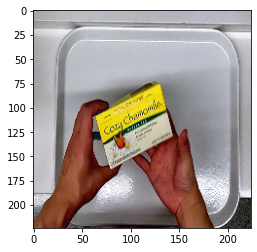

In [71]:
plt.imshow(adjusted_image)
plt.imsave("for_paper/adjusted.jpg",image)